# Showcases of `tfplot`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tfplot

In [3]:
# additional requirements:
#   scipy scikit-image Pillow seaborn

import numpy as np
from PIL import Image
import scipy

import skimage
import skimage.data

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib import rcParams, rc
from IPython.core.pylabtools import figsize

%config InlineBackend.figure_format = 'retina'

## Setup: Utilities and Data

In order to see the images generated from the plot ops, we employ a simple utility which takes a `Tensor` as an input and displays the resulting image after executing it in a TensorFlow session.

In [5]:
import tensorflow as tf
tf.InteractiveSession()

In [6]:
import IPython.display

In [7]:
def execute_plot_op(image):
    print (">>> " + str(image))
    ret = image.eval()
    plt.close()

    if len(ret.shape) == 3:
        # single image
        return Image.fromarray(ret)
    elif len(ret.shape) == 4:
        return [Image.fromarray(r) for r in ret]
    else:
        raise ValueError("Invalid rank : %d" % len(ret.shape))            

In [8]:
def execute_and_extract_image_summary(summary_op):
    from io import BytesIO
    
    # evaluate and extract PNG from the summary protobuf
    s = tf.Summary()
    s.ParseFromString(summary_op.eval())
    ims = []
    for i in range(len(s.value)):
        png_string = s.value[i].image.encoded_image_string
        im = Image.open(BytesIO(png_string))
        ims.append(im)
    plt.close()
    if len(ims) == 1: return ims[0]
    else: return ims

and some data:

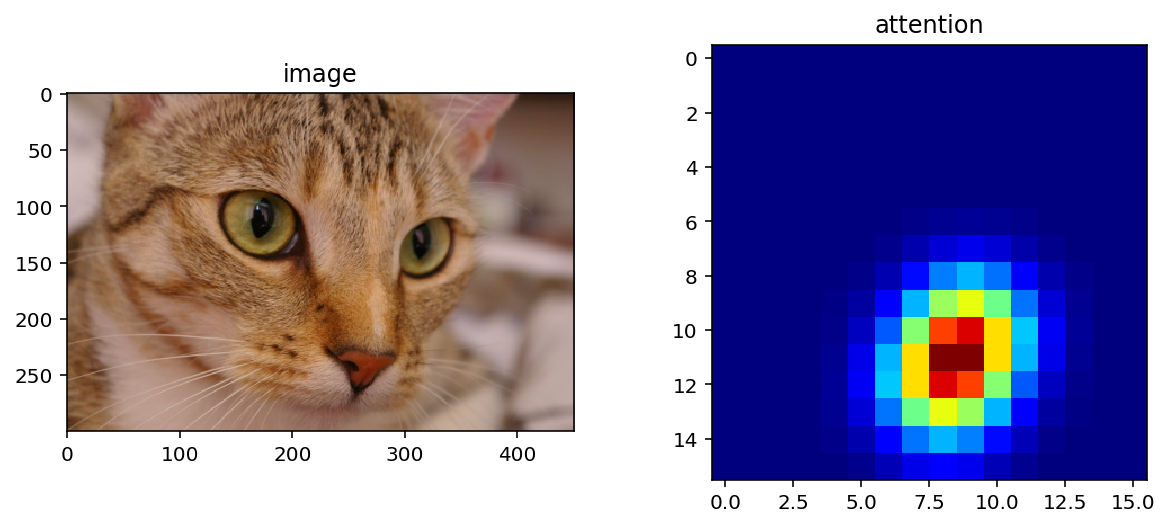

In [9]:
def fake_attention():
    import scipy.ndimage
    attention = np.zeros([16, 16], dtype=np.float32)
    attention[(12, 8)] = 1.0
    attention[(10, 9)] = 1.0
    attention = scipy.ndimage.filters.gaussian_filter(attention, sigma=1.5)
    return attention

sample_image = skimage.data.chelsea()
attention_map = fake_attention()

# display the data
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(sample_image); axs[0].set_title('image')
axs[1].imshow(attention_map, cmap='jet'); axs[1].set_title('attention')
plt.show()

And we finally wrap these numpy values into TensorFlow ops:

In [10]:
# the input to plot_op
image_tensor = tf.constant(sample_image, name='image')
attention_tensor = tf.constant(attention_map, name='attention')
print(image_tensor)
print(attention_tensor)

Tensor("image:0", shape=(300, 451, 3), dtype=uint8)
Tensor("attention:0", shape=(16, 16), dtype=float32)


## 1. Demo of `tfplot.plot()`

These examples show the usage of the most general form of the API, `tfplot.plot()`.

Conceptually, it can draw **any** matplotlib plot as a TensorFlow op. One thing to remember is that the `plot_func` function (passed to `tfplot.plot()`) should be implemented using object-oriented APIs of matplotlib, not `pyplot.XXX` APIs (or `matplotlib.pyplot.XXX`) in order to avoid thread-safety issues.

### 1.1. A basic example

>>> Tensor("Plot:0", shape=(?, ?, 4), dtype=uint8)


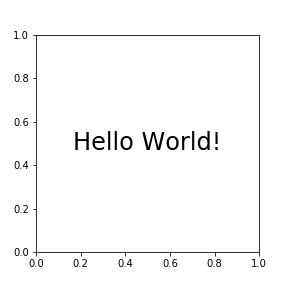

In [11]:
def test_figure():
    fig, ax = tfplot.subplots(figsize=(4, 4))
    ax.text(0.5, 0.5, "Hello World!",
            ha='center', va='center', size=24)
    return fig

plot_op = tfplot.plot(test_figure, [])
execute_plot_op(plot_op)

### 1.2. with Arguments

>>> Tensor("Plot_1:0", shape=(?, ?, 4), dtype=uint8)


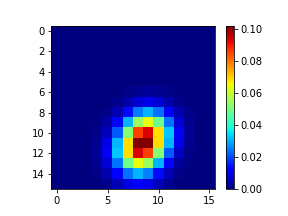

In [12]:
def figure_attention(attention):
    fig, ax = tfplot.subplots(figsize=(4, 3))
    im = ax.imshow(attention, cmap='jet')
    fig.colorbar(im)
    return fig

plot_op = tfplot.plot(figure_attention, [attention_tensor])
execute_plot_op(plot_op)

### 1.3. Examples of using kwargs

In [13]:
# the plot function can have additional kwargs for providing configuration points
def overlay_attention(attention, image,
                      alpha=0.5, cmap='jet'):
    fig = tfplot.Figure(figsize=(4, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.axis('off')
    fig.subplots_adjust(0, 0, 1, 1)  # get rid of margins
    
    H, W = attention.shape
    ax.imshow(image, extent=[0, H, 0, W])
    ax.imshow(attention, cmap=cmap,
              alpha=alpha, extent=[0, H, 0, W])
    return fig

>>> Tensor("Plot_2:0", shape=(?, ?, 4), dtype=uint8)


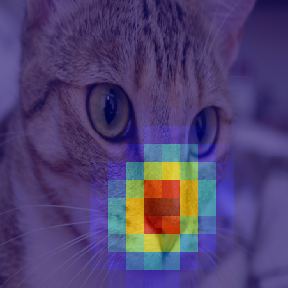

In [14]:
plot_op = tfplot.plot(overlay_attention, [attention_tensor, image_tensor])
execute_plot_op(plot_op)

>>> Tensor("Plot_3:0", shape=(?, ?, 4), dtype=uint8)


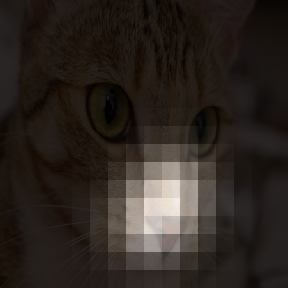

In [15]:
# the kwargs to `tfplot.plot()` are passed to the plot function (i.e. `overlay_attention`)
# during the execution of the plot operation.
plot_op = tfplot.plot(overlay_attention, [attention_tensor, image_tensor],
                      cmap='gray', alpha=0.8)
execute_plot_op(plot_op)

### 1.4. `plot_many()` -- the batch version

In [16]:
# make a fake batch
batch_size = 3
attention_batch = tf.random_gamma([batch_size, 7, 7], alpha=0.3, seed=42)
image_batch = tf.tile(tf.expand_dims(image_tensor, 0),
                      [batch_size, 1, 1, 1], name='image_batch')
print (attention_batch)
print (image_batch)

# plot_many()
plot_op = tfplot.plot_many(overlay_attention, [attention_batch, image_batch])
images = execute_plot_op(plot_op)

Tensor("random_gamma/Maximum:0", shape=(3, 7, 7), dtype=float32)
Tensor("image_batch:0", shape=(3, 300, 451, 3), dtype=uint8)
>>> Tensor("PlotMany/PlotImages:0", shape=(3, ?, ?, 4), dtype=uint8)


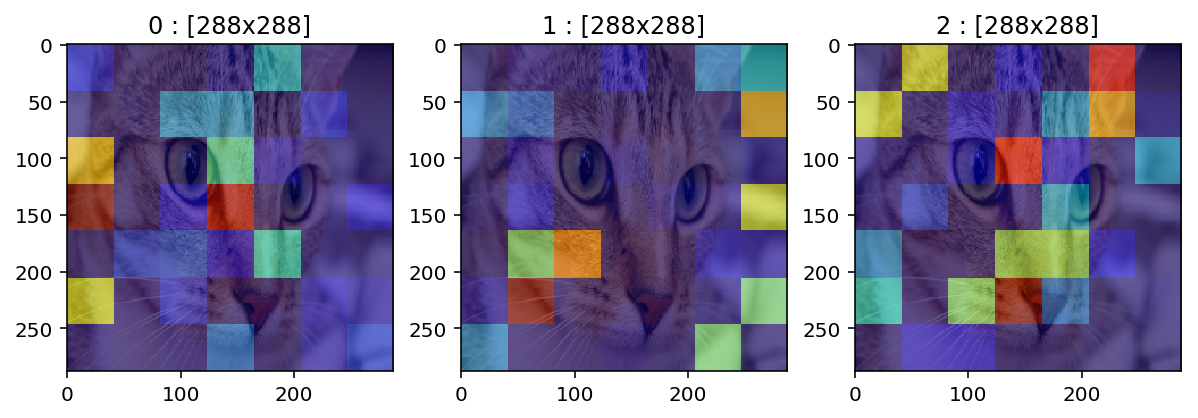

In [17]:
# just see the three images
_, axes = plt.subplots(1, 3, figsize=(10, 3))
for i in range(3):
    axes[i].set_title("%d : [%dx%d]" % (i, images[i].height, images[i].width))
    axes[i].imshow(images[i])
plt.show()

## 2. `tfplot` wrappers

More clean style in a functional way!

### 2.1. Use `tfplot.wrap()` to wrap any python plot function

Let's wrap the function `overlay_attention`, which

* takes a heatmap `attention` and a RGB image `overlay_image`
* and plots the heatmap on top of the image

as Tensors:

In [18]:
tf_plot_attention = tfplot.wrap(overlay_attention, name='PlotAttention', batch=True)
print (tf_plot_attention)

<function wrap.<locals>._wrapped_fn at 0x1138f8d90>


Then we can call the resulting `tf_plot_attention` function to build new TensorFlow ops:

In [19]:
plot_op = tf_plot_attention(attention_batch, image_batch)
images = execute_plot_op(plot_op)
images

>>> Tensor("PlotAttention/PlotImages:0", shape=(3, ?, ?, 4), dtype=uint8)


[<PIL.Image.Image image mode=RGBA size=288x288 at 0x1130FA7F0>,
 <PIL.Image.Image image mode=RGBA size=288x288 at 0x1142B98D0>,
 <PIL.Image.Image image mode=RGBA size=288x288 at 0x1142B9898>]

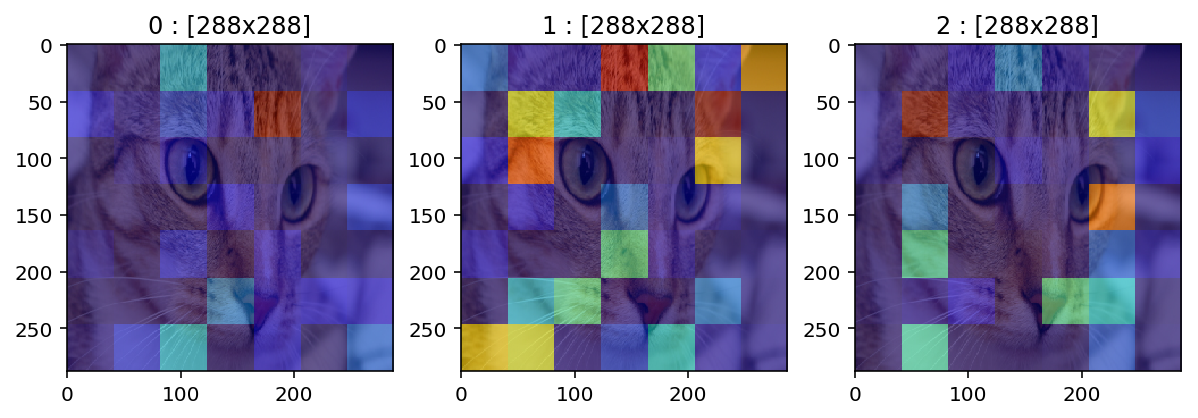

In [20]:
# just see the three images
_, axes = plt.subplots(1, 3, figsize=(10, 3))
for i in range(3):
    axes[i].set_title("%d : [%dx%d]" % (i, images[i].height, images[i].width))
    axes[i].imshow(images[i])
plt.show()

### 2.2. `tfplot.wrap_axesplot` : Wrap any Matplotlib's AxesPlot or Seaborn's Plot

#### Matplotlib

Matplotlib provides a variety of plot functions on `AxesPlot`, `ax`.

In [21]:
rs = np.random.RandomState(42)
x = rs.randn(100)
y = 2 * x + rs.randn(100)

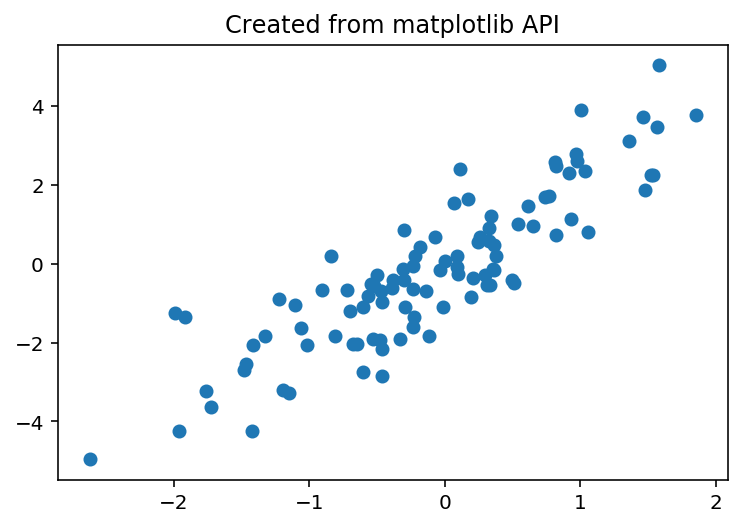

In [22]:
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_title("Created from matplotlib API")
plt.show()

We can wrap the `Axes.scatter()` method as TensorFlow op as follows:

>>> Tensor("scatter:0", shape=(?, ?, 4), dtype=uint8)


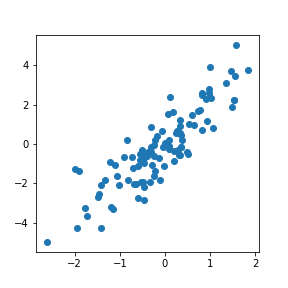

In [23]:
from matplotlib.axes import Axes
tf_scatter = tfplot.wrap_axesplot(Axes.scatter, figsize=(4, 4))

plot_op = tf_scatter(x, y)
execute_plot_op(plot_op)

#### Seaborn

Seaborn provides good axis plot utilities that can be used out-of-box. Most of functions for drawing an `AxesPlot` will have the `ax=...` parameter.

In [24]:
import seaborn.apionly as sns    

# Note: `import seaborn as sns` will affect the default matplotlib style

/Users/wookayin/.virtualenvs/tf/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


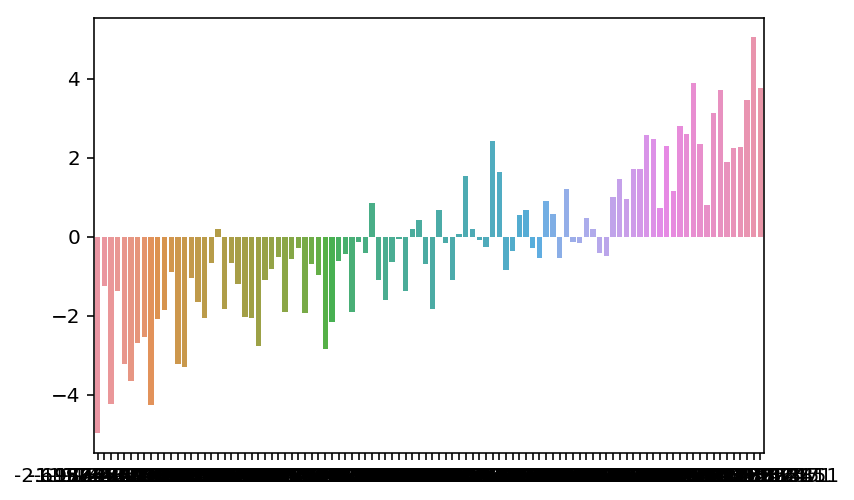

In [25]:
fig, ax = plt.subplots()
sns.barplot(x, y, ax=ax)
plt.show()

>>> Tensor("barplot:0", shape=(?, ?, 4), dtype=uint8)


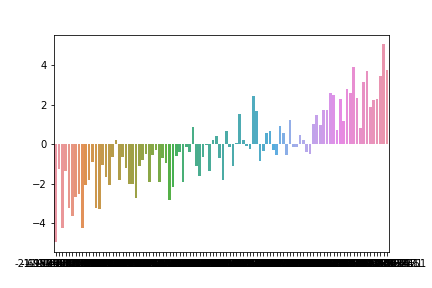

In [26]:
plot_op = tfplot.wrap_axesplot(sns.barplot)(x, y)

execute_plot_op(plot_op)

>>> Tensor("heatmap:0", shape=(?, ?, 4), dtype=uint8)


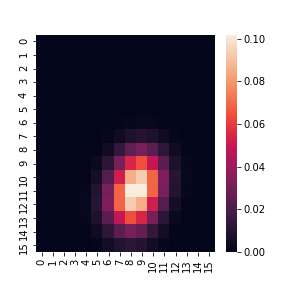

In [27]:
# wrap `sns.heatmap` as TensorFlow operation, with some additional default kwargs
tf_heatmap = tfplot.wrap_axesplot(sns.heatmap, figsize=(4,4))

execute_plot_op(
    tf_heatmap(attention_map, cbar=True)
)

>>> Tensor("HeatmapImage:0", shape=(?, ?, 4), dtype=uint8)


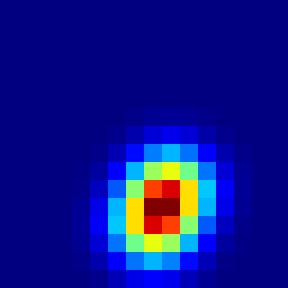

In [28]:
# print only heatmap figures other than axis, colorbar, etc.
tf_heatmap = tfplot.wrap_axesplot(sns.heatmap, figsize=(4,4), tight_layout=True,
                                  cmap='jet', cbar=False, xticklabels=False, yticklabels=False)

execute_plot_op(
    tf_heatmap(attention_map, name='HeatmapImage')
)

<br/><br/><br/><br/>

## 3. Demo of `tfplot.summary`

Finally, we can directly create a TensorFlow summary op from input tensors.

Basically it is a shortcut to creating plot ops and then creating image summaries.

In [29]:
import tfplot.summary

### 2.1. `tfplot.summary.plot()`

Tensor("plot_summary/ImageSummary:0", shape=(), dtype=string)


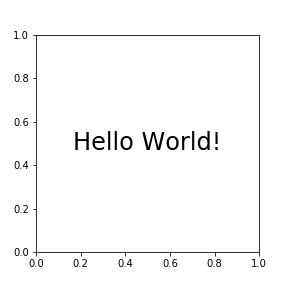

In [30]:
# Just directly add a single plot result into a summary
summary_op = tfplot.summary.plot("plot_summary", test_figure, [])
print(summary_op)
execute_and_extract_image_summary(summary_op)

### 2.2. `tfplot.summary.plot_many()` -- the batch version

In [31]:
# batch of attention maps --> image summary
batch_size, H, W = 4, 4, 4
batch_attentions = np.zeros((batch_size, H, W), dtype=np.float32)
for b in range(batch_size):
    batch_attentions[b, b, b] = 1.0
    
# Note that tfplot.summary.plot_many() takes an input in a batch form
def figure_attention_demo2(attention):
    fig, ax = tfplot.subplots(figsize=(4, 3))
    im = ax.imshow(attention, cmap='jet')
    fig.colorbar(im)
    return fig
summary_op = tfplot.summary.plot_many("batch_attentions_summary", figure_attention_demo2,
                                      [batch_attentions], max_outputs=4)
print(summary_op)
images = execute_and_extract_image_summary(summary_op)

Tensor("batch_attentions_summary/ImageSummary:0", shape=(), dtype=string)


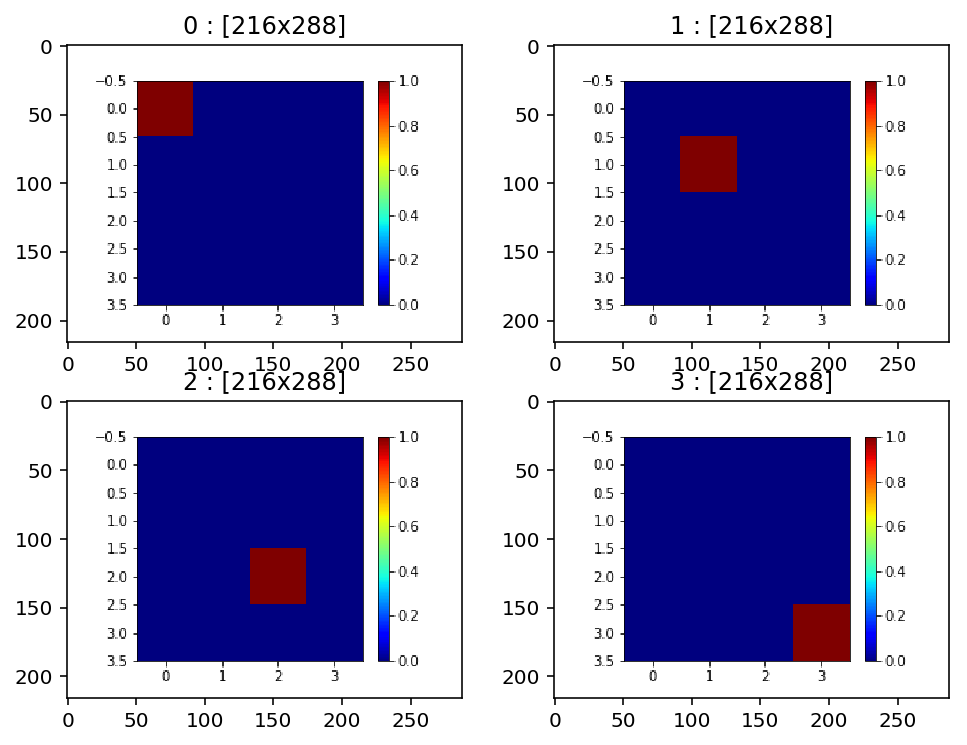

In [32]:
# just see the 4 images in the summary
_, axes = plt.subplots(2, 2, figsize=(8, 6))
for i in range(batch_size):
    axes[i//2, i%2].set_title("%d : [%dx%d]" % (i, images[i].height, images[i].width))
    axes[i//2, i%2].imshow(images[i])
plt.show()